In [0]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


In [0]:
# eager execution
tf.enable_eager_execution()
print("Eager Execution: {}".format(tf.executing_eagerly()))

Eager Execution: True


In [0]:
# functions for image processing

def load_img(loc):
    """
        function to load images
        
        loc:  location of the image on the disk

    """
    
    return np.float32(Image.open(loc))


def save_img(img, name):
    """
        img: np array of the image
        name: save name
        
        functions saves the imageon disk
    """
    
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(img, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(name, 'wb') as file:
        Image.fromarray(image).save(file, 'jpeg')

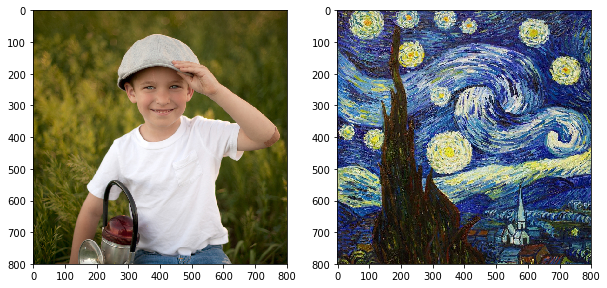

In [0]:
# visualising the content and style images
style = Image.open("style.jpg")
content = Image.open("content.jpg")

fig = plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(content)

plt.subplot(1,2,2)
plt.imshow(style)

plt.show()

In [0]:
content = np.array(content).astype(np.float32)
ch,cw,cc = content.shape
content = np.reshape(content, [1,ch,cw,cc])

style = np.array(style).astype(np.float32)
sh,sw,sc = style.shape
style = np.reshape(style, [1,sh,sw,sc])

print("content image: ",content.shape)
print("style image: ",style.shape)

content image:  (1, 800, 800, 3)
style image:  (1, 800, 800, 3)


In [0]:
# these layers of the VGG19 model will be used
# content layer
content_layers = ['block5_conv2'] 

# Style layers
style_layers = ['block2_conv2', 'block3_conv2', 'block4_conv2']

In [0]:
def load_model():
    """ loads the vgg19 model and selects the layers as in the list
    
    """
    
    model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    
    model.trainable = False
    
    # extracting the content layers
    content_model = [model.get_layer(l_name).output for l_name in content_layers]
    
    # extracting the style layers
    style_model = [model.get_layer(l_name).output for l_name in style_layers]
    
    model_output = style_model + content_model
    
    model_built = tf.keras.models.Model(model.input, model_output)
    
    return model_built

In [0]:
def content_loss(input_img, content_img):
    """ returns content loss 
    
    content loss = 0.5 * (input_img - content_img)^2
    
    input_img = generated image
    content_img = original content image
    
    """
    input_img = tf.reshape(input_img, [input_img.shape[1], input_img.shape[2], input_img.shape[3]])
    
    loss = tf.reduce_mean(tf.square(content_img - input_img))
    
    loss = tf.reshape(loss, (1,1))
    
    return loss


def gram_matrix(input_mat):
    """ returns gram matrix 
    
    * gram matrix is a dot product of the matrix to calulate the similarities across the feature maps
    * convert the matrices to vectors for height and width
    * dot product will result in a matrix of dimensions nxn where n is the no. of feature maps
    
    """
    
    
    # length*width
    lw = input_mat.shape[1]*input_mat.shape[2]
    channels = input_mat.shape[3]
    
    # reshape vector to convert it to vector
    vector = tf.reshape(input_mat, [lw, channels])
    
    gram_matrix = tf.matmul(tf.transpose(vector), vector)
    
    # normalization by dividing the pixel intensity by the width
    return gram_matrix/tf.cast(input_mat.shape[0], dtype=tf.float32)
    


def style_loss(input_img, style_img):
    """ returns style loss
    
    * style loss is a mean squared difference of gram matrix of style image and generated image,
    
    input_img = generated image
    style_img = original style image
    
    """
    
    # calculating gram matrix
    style_gram = gram_matrix(style_img)
    input_gram = gram_matrix(input_img)
    
    # calculating loss
    style_l = tf.reduce_mean(tf.square(style_gram - input_gram))
    
    style_l = tf.reshape(style_l, (1,1))

    return style_l

In [0]:
def get_features(content_img, style_img, nn_model):
    """ inputs style and content image
   
    returns feature representations of intermediate layers
    
    """
    
    # number of style layers
    n_style_layers = len(style_layers)
    
    content_output = nn_model(content_img)
    style_output = nn_model(style_img)
    
    content_features = [layer for layer in content_output[n_style_layers]]
    style_features = [layer for layer in style_output[:n_style_layers]]
    
    return content_features, style_features

In [0]:
def get_total_loss(init_img, content_features, style_features, nn_model):
    """ returns total loss 
    
    * init_img: sampled image
    * content_features: feature representations for content image
    * style_features: feature representations for style image
    * nn_model: vgg19 model
    
    """
    
    # number of style layers
    n_style_layers = len(style_layers)
    
    # computing feature representations for sampled image
    init_features = nn_model(tf.cast(init_img, tf.float32))
    
    # style and content features for init image
    init_style_features = init_features[:n_style_layers]
    init_content_features = init_features[n_style_layers:]
    
    # computing content loss
    c_loss = content_loss(init_content_features[0], content_features[0])
    
    
    # computing style loss
    s_loss = [style_loss(i,s) for i,s in zip(init_style_features, style_features)]    
    s_loss = tf.reduce_sum(s_loss)
    s_loss = tf.reshape(s_loss, (1,1))
    
    
    # loss weights
    alpha = 10
    beta = 2
    
    total_loss = alpha*c_loss + beta*s_loss
    
    return total_loss, c_loss, s_loss

In [0]:
def compute_grad(init_img, content_features, style_features, nn_model):
    """ computes derivative of the nn model
    
    arguments: init_image, content_features, style_features, nn_model
    
    returns gradient
    """
    with tf.GradientTape() as tape:
        # compute total loss
        all_loss = get_total_loss(init_img, content_features, style_features, nn_model)
        
        total_loss = all_loss[0]
  
        
        # return gradient
        return tape.gradient(total_loss[0], init_img), all_loss
    

In [0]:
def style_transfer(content_image, style_image, num_iter = 100):
    """ runs style transfer
    
    init_image: generated image
    content_image: content image
    style_image: style image
    num_iter: epochs
    
    """
    
    # load pretrained VGG19 model
    vgg = load_model()
    
    
    # making model untrainable
    for layer in vgg.layers:
        layer.trainable = False
        
        
    # content and style features from model
    # tf.constant converts ndarray to tensor
    conf, styf = get_features(tf.constant(content, tf.float32), tf.constant(style, tf.float32), vgg)
    
    
    # initial image
    init_image = tf.Variable(np.random.randn(1,800,800,3), tf.float32)
    
    # Adam optimizer
    opt = tf.train.AdamOptimizer(5.0)
    
    
    # the tutorial uses this to clip the output image
    # I don't know how they got these values...
    norm_means = np.array([103.939, 116.779, 123.68])
    min_val = -norm_means
    max_val = 255-norm_means
    
    loss_list = []
    
    # training loop
    for epoch in range(num_iter):
        # get the gradients and loss
        grads, all_loss = compute_grad(init_image, conf, styf, vgg)
        total_loss, content_loss, style_loss = all_loss
        
        # optimization
        opt.apply_gradients([(grads, init_image)])
        clipped_img = tf.clip_by_value(init_image, min_val, max_val)
        
        # update the image
        init_image.assign(clipped_img)
        
        loss_list.append(total_loss.numpy()[0][0])
        
        if epoch % 100==0:
            print("iteration: ", epoch)
        
    return init_image.numpy(), loss_list

In [0]:
num = 10

with tf.device('/gpu:0'):
    img_output, loss = style_transfer(content, style, num_iter=num)

iteration:  0


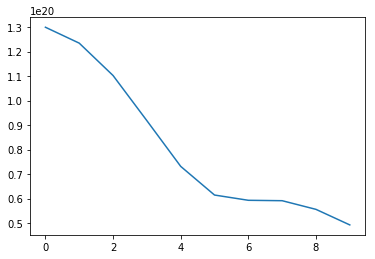

In [0]:
plt.plot(range(num), loss, '-')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


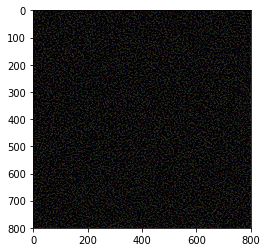

In [0]:
# plotting the final image
out = img_output.reshape((800,800,3))/255.0

plt.imshow(out)
plt.show()

###References

https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb

https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398

https://towardsdatascience.com/style-transfer-styling-images-with-convolutional-neural-networks-7d215b58f461

https://github.com/ayu34/Neural-Style-Transfer/blob/master/Neural%20Style%20Transfer.ipynb